
Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
!pip install pandas-profiling==2.*

In [0]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from pandas_profiling import ProfileReport
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot

In [4]:
data = pd.read_csv('hotel_bookings.csv')
data

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [5]:
#baseline
majority_class = data['is_canceled'].value_counts().index[0]
y_pred = [majority_class] * len(data['is_canceled'])
y_true = data['is_canceled']

accuracy_score(y_true, y_pred)

0.6295837172292487

In [7]:
profile = ProfileReport(data, minimal=True).to_notebook_iframe()

profile

In [81]:
train, test = train_test_split(data, test_size=.2, random_state=42)
train, val = train_test_split(train, test_size=.2, random_state=42)
train.shape, val.shape, test.shape

((76409, 32), (19103, 32), (23878, 32))

In [0]:
def wrangle(x):
    x = x.copy()
    x['reservation_status_date'] = x['reservation_status_date'].apply(lambda x: pd.to_datetime(x, infer_datetime_format=True))
    return x

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [10]:
target = 'is_canceled'
train_features = train.drop(columns=[target, 'reservation_status'])
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
cardinality = train_features.select_dtypes(exclude='number').nunique()
categorical_features = cardinality[cardinality <= 50].index.tolist()

features = numeric_features + categorical_features

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
)

pipeline.fit(X_train, y_train)
pipeline.score(X_val, y_val)

0.8716431974035492

In [11]:
#using xgboost in a pipeline
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    XGBClassifier(n_estimators=500, n_jobs=-1, random_state=42)
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
accuracy_score(y_val, y_pred)

0.8443699942417421

In [12]:
encoder = ce.OneHotEncoder()
scaler = StandardScaler()
imputer = SimpleImputer()

X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)

X_train_imputed = imputer.fit_transform(X_train_scaled)
X_val_imputed = imputer.transform(X_val_scaled)

model = XGBClassifier(
    n_estimators=1000,
    max_depth=7,
    learning_rate=.5,
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train),
            (X_val_encoded, y_val)]

model.fit(X_train_encoded, y_train,
          eval_set=eval_set,
          eval_metric='error',
          early_stopping_rounds=50)

[0]	validation_0-error:0.186889	validation_1-error:0.185364
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.18681	validation_1-error:0.186201
[2]	validation_0-error:0.181929	validation_1-error:0.182066
[3]	validation_0-error:0.179979	validation_1-error:0.179501
[4]	validation_0-error:0.175006	validation_1-error:0.175627
[5]	validation_0-error:0.172755	validation_1-error:0.174213
[6]	validation_0-error:0.171184	validation_1-error:0.172486
[7]	validation_0-error:0.169116	validation_1-error:0.171387
[8]	validation_0-error:0.165229	validation_1-error:0.167565
[9]	validation_0-error:0.164915	validation_1-error:0.167094
[10]	validation_0-error:0.160675	validation_1-error:0.165
[11]	validation_0-error:0.160308	validation_1-error:0.16521
[12]	validation_0-error:0.157154	validation_1-error:0.162331
[13]	validation_0-error:0.156906	validation_1-error:0.161755


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

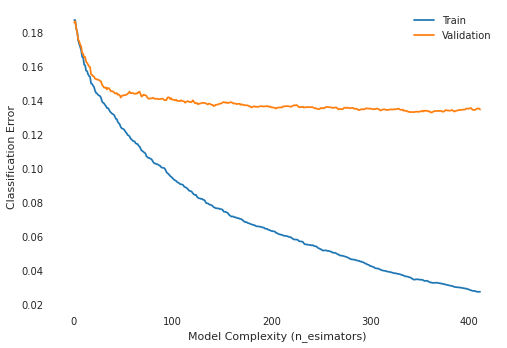

In [13]:
results = model.evals_result()
train_error = results['validation_0']['error']
val_error = results['validation_1']['error']
epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_esimators)')
plt.legend();

In [14]:
transformers = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler()
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [15]:
permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [16]:
encoder = transformers.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
encoded_columns

feature_names = encoded_columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

arrival_date_month_May        -0.000984
arrival_date_month_April      -0.000942
arrival_date_month_July       -0.000461
meal_HB                       -0.000429
arrival_date_month_February   -0.000419
                                 ...   
assigned_room_type_A           0.023159
agent                          0.024572
previous_cancellations         0.029817
lead_time                      0.035094
total_of_special_requests      0.061299
Length: 79, dtype: float64

In [17]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.0613 ± 0.0028,total_of_special_requests
0.0351 ± 0.0029,lead_time
0.0298 ± 0.0023,previous_cancellations
0.0246 ± 0.0011,agent
0.0232 ± 0.0023,assigned_room_type_A
0.0175 ± 0.0012,market_segment_Online TA
0.0154 ± 0.0035,adr
0.0126 ± 0.0012,deposit_type_No Deposit
0.0109 ± 0.0010,required_car_parking_spaces
0.0108 ± 0.0019,arrival_date_year


In [18]:
minimum_importance = 0
mask = permuter.feature_importances_ > minimum_importance
features = X_train_encoded.columns[mask]
X_train = X_train_encoded[features]

X_val = X_val_encoded[features]
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)
pipeline.score(X_val, y_val)

0.8738941527508768

In [0]:
feature = 'total_of_special_requests'

isolated = pdp_isolate(
    model=pipeline,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

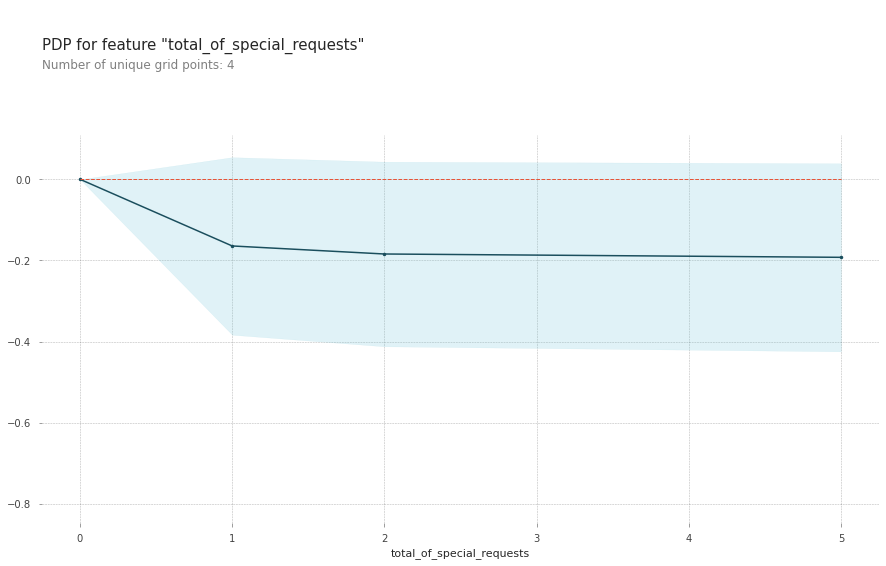

In [44]:
pdp_plot(isolated, feature_name=feature);

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fe1f12ac1d0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fe1f08fc748>})

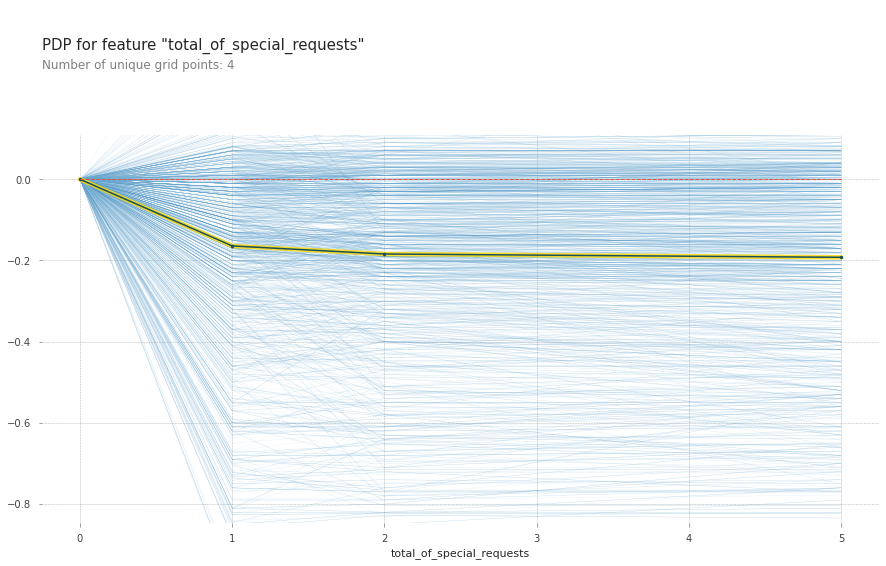

In [45]:
pdp_plot(isolated, feature_name=feature, plot_lines=True,
         frac_to_plot=.05)

In [91]:
#running model but with ordinal encoding
target = 'is_canceled'
train_features = train.drop(columns=[target, 'reservation_status'])
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
cardinality = train_features.select_dtypes(exclude='number').nunique()
categorical_features = cardinality[cardinality <= 50].index.tolist()

features = numeric_features + categorical_features

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

columns = X_train.columns

transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
)

X_train = pd.DataFrame(transformers.fit_transform(X_train), columns=columns)
X_val = pd.DataFrame(transformers.transform(X_val), columns=columns)
X_test = pd.DataFrame(transformers.transform(X_test), columns=columns)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [92]:
row = X_test.iloc[[0]]
print(y_test.iloc[[0]])
model.predict(row)

30946    0
Name: is_canceled, dtype: int64


array([0])